In [1]:
#standard libraries
from pathlib import Path
from importlib import reload

#extended libraries
import requests
import rdflib
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

#tree stuff
import anytree
import anytree.util
from anytree.importer import DictImporter
from anytree.exporter import DotExporter

#custom imports
from neurondm import *
from neurondm.models.huang2017 import Genes
from pyontutils.namespaces import ilxtr as pred
from neurondm import phenotype_namespaces as phns
from pyontutils.closed_namespaces import rdf, rdfs, owl
from nifstd.nifstd_tools.utils import ncbigenemapping
from utils import *
# from tasic2015 import *

[2019-10-10 14:13:29,353] -  WARNING -       ontquery -         terms.py:239  - <class 'neurondm.core.OntTermOntologyOnly'> has intervening instrumented classes between it and its uninstrumented form <class 'neurondm.core.OntId'>
[2019-10-10 14:13:29,356] -  WARNING -       ontquery -         terms.py:239  - <class 'neurondm.core.OntTermInterLexOnly'> has intervening instrumented classes between it and its uninstrumented form <class 'neurondm.core.OntId'>
[2019-10-10 14:13:38,785] -     INFO -       neurondm -          core.py:1431 - Unknown phenotype http://jaxmice.jax.org/strain/028577
[2019-10-10 14:13:42,581] -     INFO -       neurondm -          core.py:1431 - Unknown phenotype http://www.ncbi.nlm.nih.gov/gene/14799
[2019-10-10 14:13:42,820] -     INFO -       neurondm -          core.py:1431 - Unknown phenotype http://www.ncbi.nlm.nih.gov/gene/68939
[2019-10-10 14:13:42,873] -     INFO -       neurondm -          core.py:1431 - Unknown phenotype http://www.ncbi.nlm.nih.gov/gene/

In [2]:
%load_ext autoreload
%autoreload 1
%aimport tasic2015

In [3]:
rdflib.__version__

'5.0.0'

In [4]:
def cellguard(addns=False):
    # unfortunately ipy.hooks['pre_run_code_hook'].add(__cellguard)
    # causes this to be called too frequently :/
    setLocalNames()
    setLocalContext()
    if addns:
        setLocalNames(phns.BBP)

In [5]:
df_clf = pd.read_csv('Data/cell_classification.csv')
df_cls_mtd = pd.read_csv('Data/cluster_metadata.csv')
df_cell_mtd = pd.read_csv('Data/cell_metadata.csv')

df_cre_mtd  = pd.read_excel('Data/tasic_crelines.xlsx')

dendro = pd.read_csv("Data/web/big_tree_final.csv", dtype = {'position':str})

In [6]:
"""
Information about the cluster membership of each cell,
including whether the cell is a "core" (unambiguously assigned to a single cluster) 
or "transition" (shares membership between two clusters) cell, 
as well as its membership score (from 0-10) for each cluster (labeled f01 to f49). 
"""
df_clf.head(3)
#TODO: Only including unambiguous cells with f-values = 10 for one cluster only.

,Unnamed: 0,coretype,primary,secondary,f01,f02,f03,f04,f05,f06,...,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49
0,A200_V,Core,f01,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A201_V,Core,f02,0,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A202_V,Core,f24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
"""
 Information about each data-driven cluster, including its label, 
 the corresponding label in Tasic et al. (Nat. Neuro, 2106), the primary cell class 
 membership, and marker genes (including genes with widespread expression in the cluster, 
 sparse expression in the cluster, and no expression in the cluster). 
"""
df_cls_mtd.head(3)

,cluster_order,cluster_id,vignette_label,vignette_color,group,markers_present,markers_sparse,genes_absent,Tasic_et_al_2016_label,Unnamed: 9
0,7,f01,Vip Mybpc1,#BB36BF,Vip,"Crispld2, Cxcl14, Tpm2, Itih5, Cox6a2",Tmem182,"Npy2r, Sorl1, Car4",Vip Mybpc1,NaN
1,6,f02,Vip Cxcl14_Car4,#C994C7,Vip,"Cxcl14, Car4, Tac2","Dmp1, Syt10","Mybpc1, Npy2r, Slc44a5",Vip Parm1,NaN
2,8,f03,Vip Sncg,#9400E2,Vip,"Reln, Npy2r, Tnfaip8l3, Cadps2, 2310042E22Rik,...","Casq2, Edn3",NaN,Vip Sncg,NaN


In [8]:
"""
Information about each cell profiled, including its nomenclature, 
Cre line of origin, dissection, date of collection and sequencing, 
and read mapping statistics
"""
df_cell_mtd.head(3)

,long_name,cre,collection_date,sequencing_type,total_reads,all_mapped_percent,mRNA_percent,genome_percent,ercc_percent,tdt_permillion,major_class,sub_class,major_dissection,layer_dissectoin,color_code,short_name
0,A01101401,Calb2,11/18/2013,hiseq,23770190,93.50,54.43,30.08,4.36,306.1,Inhibitory,Vip,V1,All,11,A200_V
1,A01101402,Calb2,11/18/2013,hiseq,9694719,92.86,45.69,35.45,7.84,341.2,Inhibitory,Vip,V1,All,11,A201_V
2,A01101403,Calb2,11/18/2013,hiseq,5864322,90.55,48.30,34.01,4.12,106.2,Excitatory,L4,V1,All,11,A202_V


In [9]:
df_clf.rename(index=str, columns={"Unnamed: 0":"cell_index"}, inplace = True)
df_clf = df_clf[['cell_index','coretype', 'primary', 'secondary']]

#Reorder and drop columns that are not interesting
df_cell_mtd = df_cell_mtd[['short_name','cre','major_class','sub_class',
                           'major_dissection', 'layer_dissectoin']]
df_cls_mtd = df_cls_mtd[['cluster_id','cluster_order','vignette_label',
                         'group','markers_present','markers_sparse',
                         'genes_absent','Tasic_et_al_2016_label']]

df_cls_mtd['cluster_id'] = df_cls_mtd['cluster_id'].astype(str)

#merge
df_types = df_cell_mtd.merge(df_clf, left_on='short_name', right_on='cell_index')
df_types = df_types[['short_name', 'coretype', 'primary', 'secondary',
                     'cre','major_dissection', 'layer_dissectoin']]

In [10]:
#cre line conversion metadata
df_cre_mtd.head(3)

,#,Driver Line,Abbreviation,Originating Lab (Donating Investigator),Primary Reference,Generation Method,"Generation Method, more detail",Public Repository,Public Repository Stock #,Repository Strain Name,Data available through the Allen Institute Transgenic Portal
0,1.0,Calb2-IRES-Cre,Calb2,Z. Josh Huang,"Taniguchi et al., Neuron 2011",Knock-in,IRES,The Jackson Laboratory,10774.0,B6(Cg)-Calb2tm1(cre)Zjh/J,http://connectivity.brain-map.org/transgenic/s...
1,2.0,Chat-IRES-Cre,Chat,Brad Lowell,"Rossi et al., Cell Metab. 2011",Knock-in,IRES,The Jackson Laboratory,6410.0,B6;129S6-Chattm1(cre)Lowl/J,http://connectivity.brain-map.org/transgenic/s...
2,3.0,Chrna2-Cre_OE25,Chrna2,Nathaniel Heintz and Charles Gerfen,"Gerfen et al., Neuron 2013",Transgenic,BAC,MMRRC,36502.0,STOCK Tg(Chrna2-cre)OE25Gsat/Mmucd,http://connectivity.brain-map.org/transgenic/s...


In [11]:
#final combined table for cluster, layer, & cre
df_types.head(3)

,short_name,coretype,primary,secondary,cre,major_dissection,layer_dissectoin
0,A200_V,Core,f01,0,Calb2,V1,All
1,A201_V,Core,f02,0,Calb2,V1,All
2,A202_V,Core,f24,0,Calb2,V1,All


main dataframe: df_types

metadata: cre_mtd & cls_mtd

## Dendrogram Parsing

In [12]:
dendro.head()

,cluster,position
0,Cd34,000000
1,Ndnf Car4,0000010
2,Ndnf Cxcl14,0000011
3,Vip Gpc3,0000100
4,Vip Chat,0000101


In [13]:
tree_dict = {'label':'root'} #base dictionary

#parses binary node positions into a dictionary with tree structure
for label, bin_str in zip(dendro['cluster'], dendro['position']):
    parse_binary(tree_dict, bin_str, label)

In [14]:
importer = DictImporter()
tree = importer.import_(tree_dict)

for ind, node in enumerate(anytree.LevelOrderIter(tree)):
    node.pos = ind + 1 #node index starting at one
    if node.is_leaf:
        node.name = str(ind + 1) + " " + node.label
    else:
        node.name = str(ind + 1)
        
print(anytree.RenderTree(tree))
DotExporter(tree).to_picture("dendro.png")

#node.name for rendering
#node.pos & node.label used for parsing

AnyNode(label='root', name='1', pos=1)
├── AnyNode(name='2', pos=2)
│   ├── AnyNode(name='4', pos=4)
│   │   ├── AnyNode(name='8', pos=8)
│   │   │   ├── AnyNode(name='16', pos=16)
│   │   │   │   ├── AnyNode(name='28', pos=28)
│   │   │   │   │   ├── AnyNode(label='Cd34', name='42 Cd34', pos=42)
│   │   │   │   │   └── AnyNode(name='43', pos=43)
│   │   │   │   │       ├── AnyNode(label='Ndnf Car4', name='60 Ndnf Car4', pos=60)
│   │   │   │   │       └── AnyNode(label='Ndnf Cxcl14', name='61 Ndnf Cxcl14', pos=61)
│   │   │   │   └── AnyNode(name='29', pos=29)
│   │   │   │       ├── AnyNode(name='44', pos=44)
│   │   │   │       │   ├── AnyNode(label='Vip Gpc3', name='62 Vip Gpc3', pos=62)
│   │   │   │       │   └── AnyNode(label='Vip Chat', name='63 Vip Chat', pos=63)
│   │   │   │       └── AnyNode(name='45', pos=45)
│   │   │   │           ├── AnyNode(name='64', pos=64)
│   │   │   │           │   ├── AnyNode(label='Vip Cxcl14_Car4', name='80 Vip Cxcl14_Car4', pos=80)
│   │   │  

In [15]:
for leaf in tree.leaves: #TODO: phenotypes & deal with mismatching
    #edge cases for the last two endothelial cells
    if leaf.label  == 'Endo Tbc1d4':
        leaf.cluster_id = 'f48'
    elif leaf.label == 'Endo Myl9':
        leaf.cluster_id = 'f49'
    else:
        leaf.cluster_id = list(df_cls_mtd[df_cls_mtd['vignette_label'] == leaf.label]['cluster_id'])[0]
    
    #FIXME: label name matching somehow not working
    """
    genes_present = list(df_cls_mtd[df_cls_mtd['cluster_id'] == leaf.cluster_id]['markers_present'].str.split(","))
    genes_absent = list(df_cls_mtd[df_cls_mtd['cluster_id'] == leaf.cluster_id]['genes_absent'].str.split(","))
    if genes_present == np.nan:
        leaf.genes_present = set()
    if genes_absent == np.nan:
        leaf.genes_absent = set()
    else:
        leaf.genes_present = set(genes_present[0])
        #leaf.genes_absent = set(genes_absent)
    """

In [16]:
#gene and cluster columns converted from dendrogram structure
df_types['cluster'] = df_types.apply(cluster_converter, tree = tree, axis = 1)
df_types['markers_present'] = df_types.apply(gene_merge, df = df_cls_mtd, index = 'markers_present', axis = 1)
df_types['markers_absent'] = df_types.apply(gene_merge, df = df_cls_mtd, index = 'genes_absent', axis = 1)

In [17]:
df_types[df_types['coretype'] == 'Transition'].head(3)

,short_name,coretype,primary,secondary,cre,major_dissection,layer_dissectoin,cluster,markers_present,markers_absent
8,A272_V,Transition,f24,f28,Calb2,V1,All,10,{},"{ Endou, Fam19a1, Kitl, Scnn1a, Gm13629, Z..."
15,A279_V,Transition,f07,f02,Calb2,V1,All,16,{},"{Mybpc1, Car4, Slc44a5, Npy2r}"
26,A1612_V,Transition,f32,f39,Calb2,V1,All,11,{},"{ Pter, Ntrk3, C1ql3, Slc30a3}"


In [18]:
response = requests.get('http://api.brain-map.org/api/v2/data/query.json?criteria='
                        'model::TransgenicLine,rma::options[num_rows$eqall]')
cre_ref = pd.DataFrame(response.json()['msg'])
cre_ref['stock_number'] = pd.to_numeric(cre_ref['stock_number'])

#creates final cre metadata based on a name merge & a stock number merge
cre_df1 = pd.merge(df_cre_mtd, cre_ref,  how='inner',
                   left_on='Driver Line',right_on = 'name')

cre_df2 = pd.merge(df_cre_mtd.dropna(subset = ['Public Repository Stock #']),
                   cre_ref.dropna(subset = ['stock_number']),  how='inner',
                   left_on='Public Repository Stock #',
                   right_on = 'stock_number')

#drop duplicates
cre_df1.drop_duplicates(inplace = True)
cre_df2.drop_duplicates(inplace = True)
cre_df = pd.concat([cre_df1, cre_df2], axis = 0)
cre_df.drop_duplicates(inplace = True)

#reorder
cre_df = cre_df[['Abbreviation','name', 'id', 'stock_number',
                 'transgenic_line_source_name',
                 'transgenic_line_type_name',
                 'url_prefix', 'url_suffix','description']]

### Data Visualization

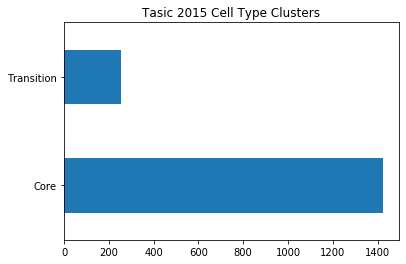

In [19]:
pd.value_counts(df_types['coretype']).plot.barh();
plt.title("Tasic 2015 Cell Type Clusters");

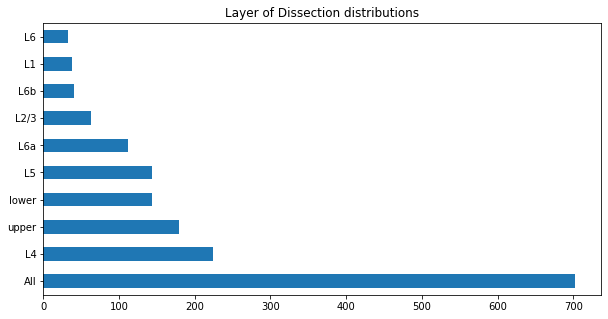

In [20]:
pd.value_counts(df_types['layer_dissectoin']).plot.barh(figsize = (10,5));
plt.title("Layer of Dissection distributions");

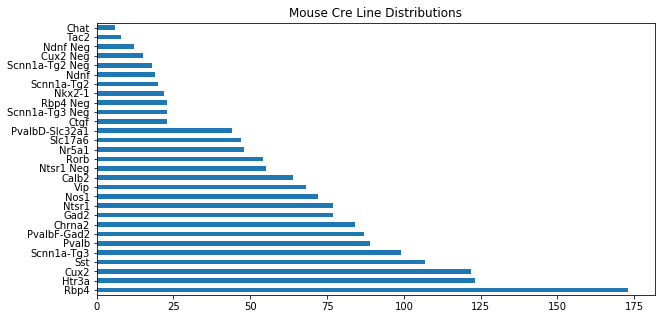

In [21]:
pd.value_counts(df_types['cre']).plot.barh(figsize = (10,5));
plt.title("Mouse Cre Line Distributions");

### Phenotype Bagging

In [22]:
#Tables should now be in final version
df_types.head(3)

,short_name,coretype,primary,secondary,cre,major_dissection,layer_dissectoin,cluster,markers_present,markers_absent
0,A200_V,Core,f01,0,Calb2,V1,All,81,"{ Cox6a2, Tpm2, Itih5, Crispld2, Cxcl14}","{ Car4, Npy2r, Sorl1}"
1,A201_V,Core,f02,0,Calb2,V1,All,80,"{Cxcl14, Car4, Tac2}","{Mybpc1, Slc44a5, Npy2r}"
2,A202_V,Core,f24,0,Calb2,V1,All,70,"{ Lmo3, Rorb, Inhba, Sparcl1, Pde1a, Whrn...","{ Kitl, Scnn1a, Endou, Fam19a1}"


In [23]:
df_cre_mtd[df_cre_mtd['Abbreviation'] == 'Ndnf']

,#,Driver Line,Abbreviation,Originating Lab (Donating Investigator),Primary Reference,Generation Method,"Generation Method, more detail",Public Repository,Public Repository Stock #,Repository Strain Name,Data available through the Allen Institute Transgenic Portal
7,8.0,Ndnf-IRES2-dgCre,Ndnf,Allen Institute for Brain Science,This paper,Knock-in,IRES2,NaN,NaN,NaN,http://connectivity.brain-map.org/transgenic/s...


In [24]:
len(df_types['cre'].value_counts())

29

In [25]:
len(df_cre_mtd)

27

In [26]:
#We're supposed to have 29 cre-line types
len(cre_df)

24

In [28]:
pd.diff(cre_df['Abbreviation'], df_types['cre'])

AttributeError: module 'pandas' has no attribute 'diff'

In [44]:
b = sorted(cre_df['Abbreviation'].items())
b

[(0, 'Calb2'),
 (1, 'Chat'),
 (1, 'Chrna2'),
 (2, 'Cux2'),
 (3, 'Gad2'),
 (4, 'Htr3a'),
 (5, 'Ndnf'),
 (6, 'Nkx2.1'),
 (6, 'Nos1'),
 (7, 'Nr5a1'),
 (8, 'Ntsr1'),
 (9, 'Pvalb'),
 (10, 'PvalbD'),
 (10, 'Rbp4'),
 (11, 'PvalbF'),
 (11, 'Rorb'),
 (12, 'Scnn1a-Tg2'),
 (13, 'Scnn1a-Tg3'),
 (14, 'Slc17a6'),
 (15, 'Slc32a1'),
 (16, 'Sst'),
 (17, 'Tac1'),
 (18, 'Vip'),
 (19, 'Trib2*')]

In [45]:
a = sorted(df_types['cre'].value_counts().items())
a

[('Calb2', 64),
 ('Chat', 6),
 ('Chrna2', 84),
 ('Ctgf', 23),
 ('Cux2', 122),
 ('Cux2 Neg', 15),
 ('Gad2', 77),
 ('Htr3a', 123),
 ('Ndnf', 19),
 ('Ndnf Neg', 12),
 ('Nkx2-1', 22),
 ('Nos1', 72),
 ('Nr5a1', 48),
 ('Ntsr1', 77),
 ('Ntsr1 Neg', 55),
 ('Pvalb', 89),
 ('PvalbD-Slc32a1', 44),
 ('PvalbF-Gad2', 87),
 ('Rbp4', 173),
 ('Rbp4 Neg', 23),
 ('Rorb', 54),
 ('Scnn1a-Tg2', 20),
 ('Scnn1a-Tg2 Neg', 18),
 ('Scnn1a-Tg3', 99),
 ('Scnn1a-Tg3 Neg', 23),
 ('Slc17a6', 47),
 ('Sst', 107),
 ('Tac2', 8),
 ('Vip', 68)]

In [47]:
list(zip(a,b))

[(('Calb2', 64), (0, 'Calb2')),
 (('Chat', 6), (1, 'Chat')),
 (('Chrna2', 84), (1, 'Chrna2')),
 (('Ctgf', 23), (2, 'Cux2')),
 (('Cux2', 122), (3, 'Gad2')),
 (('Cux2 Neg', 15), (4, 'Htr3a')),
 (('Gad2', 77), (5, 'Ndnf')),
 (('Htr3a', 123), (6, 'Nkx2.1')),
 (('Ndnf', 19), (6, 'Nos1')),
 (('Ndnf Neg', 12), (7, 'Nr5a1')),
 (('Nkx2-1', 22), (8, 'Ntsr1')),
 (('Nos1', 72), (9, 'Pvalb')),
 (('Nr5a1', 48), (10, 'PvalbD')),
 (('Ntsr1', 77), (10, 'Rbp4')),
 (('Ntsr1 Neg', 55), (11, 'PvalbF')),
 (('Pvalb', 89), (11, 'Rorb')),
 (('PvalbD-Slc32a1', 44), (12, 'Scnn1a-Tg2')),
 (('PvalbF-Gad2', 87), (13, 'Scnn1a-Tg3')),
 (('Rbp4', 173), (14, 'Slc17a6')),
 (('Rbp4 Neg', 23), (15, 'Slc32a1')),
 (('Rorb', 54), (16, 'Sst')),
 (('Scnn1a-Tg2', 20), (17, 'Tac1')),
 (('Scnn1a-Tg2 Neg', 18), (18, 'Vip')),
 (('Scnn1a-Tg3', 99), (19, 'Trib2*'))]

## Writing & Serializing

In [27]:
ttl_test_path = '/var/host/media/removable/SD Card/Neuron/Tasic/ttl_export'
config = Config("tasic-2015", ttl_export_dir=Path(ttl_test_path))
tb = TasicBagger(data = df_types, **metadata)
ind = 0
for label, bag in tb.bags:
    if ind == 1:
        break
    TasicNeuron(*bag, label = label, override=True)
    ind += 1
config.write()
config.write_python()

NameError: name 'TasicBagger' is not defined

In [ ]:
from neurondm.sheets import Sheet
from neurondm import OntId, OntTerm, Config, NeuronEBM, Neuron
from pyontutils.utils import byCol, relative_path
from pyontutils.namespaces import ilxtr
from pyontutils.closed_namespaces import rdfs

main()

In [ ]:
metadata = {"cre":cre_df}
tb = TasicBagger(data = df_types, **metadata)
tb.build_transgenic_lines()

### Test Code

In [ ]:
# metada query test
df_cre_mtd[df_cre_mtd['Abbreviation'] == df_types['cre'][12]]

In [ ]:
def main():
    metadata = {"cre": cre_df}
    ttl_test_path = '/mnt/c/Users/allen/Desktop/Neuron/Tasic2015/ttl_export'
    config = Config("tasic-2015", ttl_export_dir=Path(ttl_test_path))
    tb = TasicBagger(data=df_types, **metadata)
    ind = 0
    for label, bag in tb.bags:
        if ind == 10:
            break
        TasicNeuron(*bag, label=label, override=True)
        ind += 1
    config.write()

In [ ]:
with Tasic2015:
    print(Mouse)

In [ ]:
simpleOnt()

In [ ]:
Phenotype("ilxtr:cluster6", "ilxtr:hasComputedMolecularPhenotype", label = "Tasic2015", check = False)

In [ ]:
from pyontutils.utils import byCol, relative_path
from pyontutils.namespaces import ilxtr
from pyontutils.closed_namespaces import rdfs

In [ ]:
with Neuron(phns.Species.Mouse, phns.Regions.V1) as context:
    print(context)
    n11 = Neuron(phns.Layers.L1)
    print(n11)